# Overview
This notebook demonstrates processing and basic analysis of RAD7 data series (from `.r7raw` files), utilizing packages from `src/`.

### 1. Load data 
* Load `.r7raw` file into a Dataframe
* Verify the RAD7 run has consistent units (of concentration or temperature)
* Select columns to analyze

### 2. Saving data to file (example)
* Save data to `.parquet` file
* Load the file back as a Dataframe

### 3. Simple plotting
* Plot radon concentration vs. time

In [6]:
# Imports
# RAD7 data processing packages
from src.utils import (
    parse_raw_data,
    get_unit
)

# Data manipulation
import pandas as pd

# Plotting
import matplotlib.pyplot as plt


In [7]:
# Get r7raw data file to process.
raw_data_path = "rad7_data/RAD7 04261 Data 2026-01-28.r7raw"
rad7_run_df = parse_raw_data(raw_data_path)

# Check dataframe looks good (debugging).
# rad7_run_df.head

# Check dataframe columns.
rad7_run_df.columns

Index(['Total Counts', 'Live Time', '% of total counts in win. A',
       '% of total counts in win. B', '% of total counts in win. C',
       '% of total counts in win. D', 'High Voltage Level',
       'High Voltage Duty Cycle', 'Temperature',
       'Relative humidity of sampled air', 'Leakage Current',
       'Battery Voltage', 'Pump Current', 'Radon concentration',
       'Radon concentration uncertainty', 'Timestamp', 'Pump State',
       'Thoron On', 'Measurement Type', 'Auto Mode', 'Sniff Mode',
       'Concentration Unit', 'Temperature Unit'],
      dtype='str')

In [8]:
# Get units of quantities for this run (either Concentration Unit or Temperature Unit).
# get_unit() checks that the unit is the same throughout this run (column) and returns the string.
conc_unit = get_unit(rad7_run_df, "Concentration Unit")   # Radon concentration unit

# Get bin size (difference between timestamps). Use this metadata for plot labelling later on.

# print(f"Sampling length: {bin_size}")

# Choose which columns you want to analyze or save.
rad_conc_df = rad7_run_df[[
    'Timestamp', 
    'Radon concentration', 
    'Radon concentration uncertainty'
]].copy()

# Rename the concentration column to contain the unit.
rad_conc_df.rename(columns={"Radon concentration": f"Radon concentration ({conc_unit})"}, inplace=True)

In [ ]:
# Skip this cell if not wanting to save off this data to a file and you want to go to plotting.

# Save it to a parquet file (example)
save_path = "rad7_run_01282026.parquet"
rad_conc_df.to_parquet(save_path, index=False)   # The index of the dataframe is just integer numbering that we dont care to save.

# Load it back as a dataframe, with timestamp as its Index (for easier plotting and re-binning).
radon_df = pd.read_parquet(save_path)
radon_df.set_index("Timestamp", inplace=True)   

# Note: To save a dataframe WITH the index set (as a column you care about, like Timestamp), 
# make sure to do index=True when saving to parquet.

In [13]:
# Note: Inspect the column names if you want to access columns this way (you can copy and paste the column names like as below)
rad_conc_df.columns

Index(['Radon concentration (Total Counts)', 'Radon concentration uncertainty'], dtype='str')

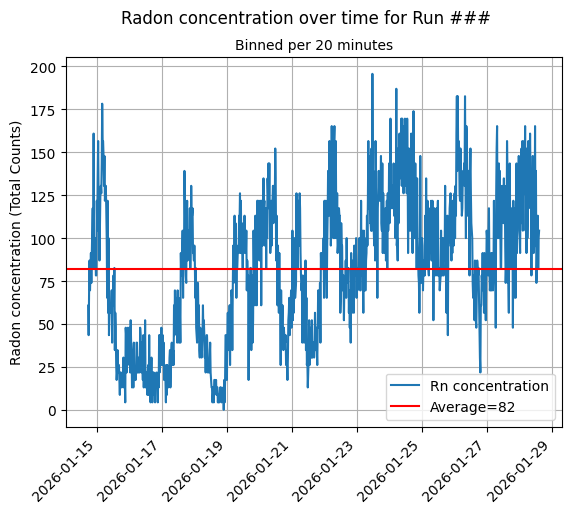

In [23]:
# Plotting
# Get radon concentration series (column at position 0). Column name can also be used.
radon_conc_arr = rad_conc_df.iloc[:, 0]
# radon_conc_arr = radon_df["Radon concentration (Total Counts)"]   # Equivalent to above, with copied column name from previous output

# Plot radon concentration vs time.
plt.plot(
    rad_conc_df.index,   # x-axis: Timestamp
    radon_conc_arr,   # y-axis: Radon concentration
    label="Rn concentration"
)

# Add a horizontal line indicating the average 
avg_rad_conc = radon_conc_arr.mean()        # Calculate average radon concentration
avg_rad_conc = int(avg_rad_conc.round(1))   # Round to nearest integer
plt.axhline(y=avg_rad_conc, color='r', label=f'Average={avg_rad_conc}')

plt.xticks(rotation=45, ha='right')   # Tilt timestamp labels
plt.ylabel(rad_conc_df.columns[0])   # Name of radon concentration column (has the units added to it from earlier)
plt.suptitle("Radon concentration over time for Run ###")
plt.title("Binned per 20 minutes", fontsize=10)
plt.grid(True)   # Add grid lines
plt.legend()     # Show legend (line labels)
plt.show()

In [ ]:
# Plot radon concentration *with error bars*
plt.errorbar(
    